# NLP Going Deeper 10 : Transformer로 번역기 만들기

나름대로 혁신적이었던 **Sequence-to-Sequence(seq2seq)** 구조로 번역기를 만들었으나, 그 성능이 기대에 미치지 않았던 경우가 있었을 것입니다.

오늘 다루게 될 자연어 처리 모델인 **트랜스포머(Transformer)** 는 현재까지도 각종 번역 부문에서 최고의 성능을 자랑하는 모델입니다!

이번에야말로 seq2seq를 능가할 만한 멋진 번역기를 만들어 볼 수 있지 않을까 생각합니다. 트랜스포머 모델은 앞으로도 NLP 분야에서 어느 곳에도 빠지지 않는 가장 중요한 모델 구조의 근간이 되기 때문에, 이번 프로젝트 노드 실습을 통해 트랜스포머의 구조를 제대로 알고 갑시다. 😎😎

## 실습환경 설정 & 라이브러리 import

우선, 모든 것의 시작은 실습환경을 세팅하는 것에서부터! 아래 예시처럼 **작업 디렉토리를 생성하고 터미널 내에서 나눔 글꼴을 설치해줍니다.**

나눔 글꼴 설치의 경우, 이후 진행될 한국어 시각화 및 올바른 Attention Map을 확인하기 위해 꼭 필요한 과정이니 설치할 것을 권장합니다.

참고로, matplotlib 라이브러리의 기본 폰트는 한국어를 지원하지 않습니다.

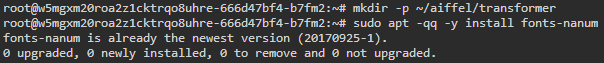

아래 코드를 실행하여 무사히 넘어가지는지 확인해 봅시다.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

%config InlineBackend.figure_format = 'retina'
 
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

print("무사통과! 환영합니다.😎😎")

무사통과! 환영합니다.😎😎


프로젝트에 필요한 라이브러리들입니다. import 해주셔야겠죠?

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import re
import os
import io
import time
import random

import seaborn # Attention 시각화를 위해 필요!

print('당신의 Tensorflow 버전은', tf.__version__, '입니다.')

당신의 Tensorflow 버전은 2.4.1 입니다.


## Transformer 내부 모듈 구현 : Positional Encoding

오늘 우리는 Transformer를 완성하는 데 필요한 모듈들을 하나하나 만든 다음 조립하여 완성시키고자 합니다.

우선, **제 1단계 - Positional Encoding** 입니다.

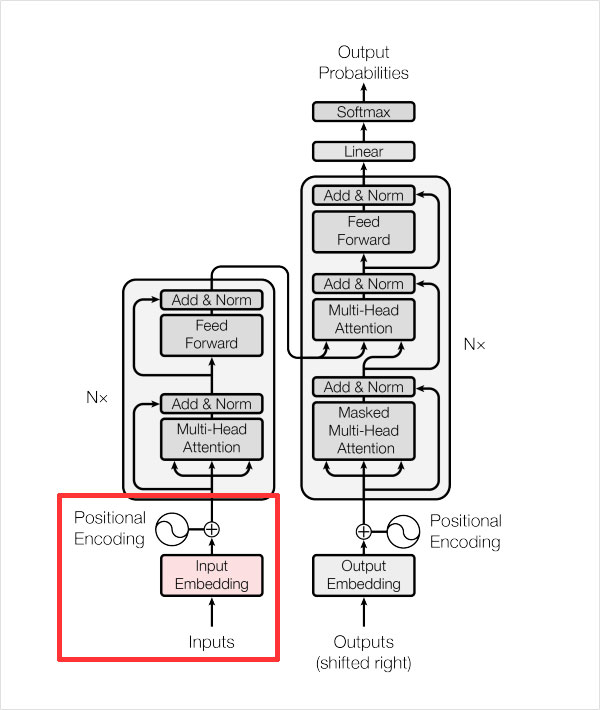

In [3]:
# 가급적 이 소스를 그대로 사용하는 것이 좋을 것 같습니다..
def positional_encoding(pos, d_model):
    def cal_angle(position, i):
        return position / np.power(10000, int(i) / d_model)

    def get_posi_angle_vec(position):
        return [cal_angle(position, i) for i in range(d_model)]

    sinusoid_table = np.array([get_posi_angle_vec(pos_i) for pos_i in range(pos)])
    sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
    sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])
    return sinusoid_table

print("Positional Encoding 구현 완료!")

Positional Encoding 구현 완료!


## Transformer 내부 모듈 구현 : Multi-Head Attention

**제 2단계 - Multi-Head Attention** 입니다.

Multi-Head Attention은 여러 개의 서브 모듈을 결합하여 완성됩니다. 구성 요소가 되는 서브 모듈은 다음과 같습니다.

- Embedding된 입력을 Head 수로 분할하는 **split_heads()**
- 분할된 입력으로부터 Attention 값을 구하는 **scaled_dot_product_attention()**
- 연산이 종료되고 분할된 Head를 다시 하나로 결합시켜주는 **combine_heads()**

뭔가 빠진 것 같다면 그것은 바로 Masking 부분일 것입니다.

마스크의 형태를 결정하는 것이 모델 외부의 훈련 데이터이기 때문에 그를 생성하는 함수는 Multi-Head Attention 외부에 정의되어질 것입니다.

마스크를 생성하는 함수는 모델을 완성한 후에 구현하는 대신, 생성된 마스크를 처리할 수 있도록 scaled_dot_product_attention() 에는 아래 내용을 포함하길 바랍니다.

```
# scaled_qk: Attention을 위한 Softmax 직전의 Scaled QK
if mask is not None: scaled_qk += (mask * -1e9)
```

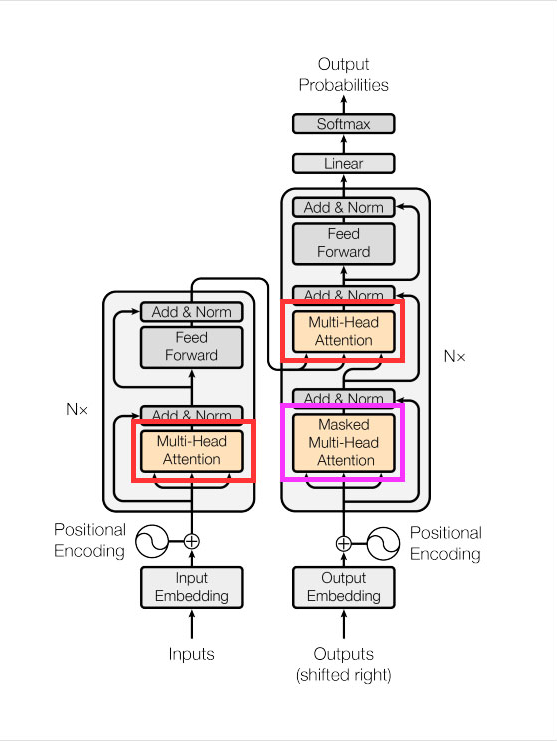

In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
            
        self.depth = d_model // self.num_heads
            
        self.W_q = tf.keras.layers.Dense(d_model)
        self.W_k = tf.keras.layers.Dense(d_model)
        self.W_v = tf.keras.layers.Dense(d_model)
            
        self.linear = tf.keras.layers.Dense(d_model)

    def scaled_dot_product_attention(self, Q, K, V, mask):
        d_k = tf.cast(K.shape[-1], tf.float32)
        QK = tf.matmul(Q, K, transpose_b=True)

        scaled_qk = QK / tf.math.sqrt(d_k)

        if mask is not None: scaled_qk += (mask * -1e9)  

        attentions = tf.nn.softmax(scaled_qk, axis=-1)
        out = tf.matmul(attentions, V)

        return out, attentions
    
    def split_heads(self, x):
        batch_size = x.shape[0]
        split_x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        split_x = tf.transpose(split_x, perm=[0, 2, 1, 3])

        return split_x

    def combine_heads(self, x):
        batch_size = x.shape[0]
        combined_x = tf.transpose(x, perm=[0, 2, 1, 3])
        combined_x = tf.reshape(combined_x, (batch_size, -1, self.d_model))

        return combined_x

    def call(self, Q, K, V, mask):
        WQ = self.W_q(Q)
        WK = self.W_k(K)
        WV = self.W_v(V)
        
        WQ_splits = self.split_heads(WQ)
        WK_splits = self.split_heads(WK)
        WV_splits = self.split_heads(WV)
            
        out, attention_weights = self.scaled_dot_product_attention(
            WQ_splits, WK_splits, WV_splits, mask)
       
        out = self.combine_heads(out)
        out = self.linear(out)
                
        return out, attention_weights

주의할 점은 Multi-Head Attention을 구현할 때 Head를 나눈다는 개념을 이해하지 못해서 반복문을 돌며 [idx : idx + self.depth] 로 인덱싱해서 처리를 하는 경우가 있는데, 이 경우 연산이 죽을 만큼 오래 걸릴 수 있습니다.. 😭😭

## Transformer 내부 모듈 구현 : Position-wise Feed-Forward Network

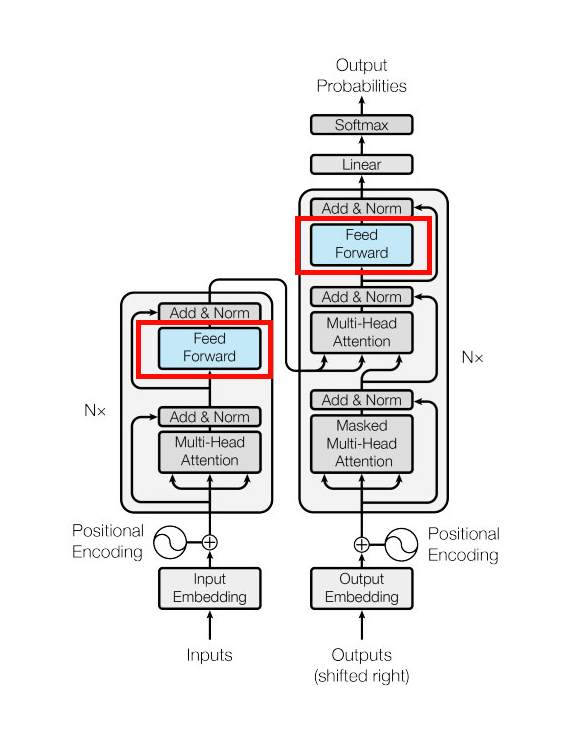

In [5]:
class PoswiseFeedForwardNet(tf.keras.layers.Layer):
    def __init__(self, d_model, d_ff):
        super(PoswiseFeedForwardNet, self).__init__()
        self.w_1 = tf.keras.layers.Dense(d_ff, activation='relu')
        self.w_2 = tf.keras.layers.Dense(d_model)

    def call(self, x):
        out = self.w_1(x)
        out = self.w_2(out)
            
        return out
    
print('여기까지.. 괜찮으시죠? 😂😂')

여기까지.. 괜찮으시죠? 😂😂


우리는 이것으로서 내부에 포함될 모듈들을 모두 완성했습니다. 이렇게 완성된 모듈들을 가지고 트랜스포머를 구현할 수 있는데, 정확하게는 트랜스포머의 Encoder 한 층과 Decoder 한 층을 각각 완성할 수 있습니다.

한편, **조금 더 멋지고 효율적인 방법으로 트랜스포머를 완성할 수 있는 방법**이 있습니다.

## Transformer 모듈 조립 : Encoder 레이어 구현

In [6]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, n_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()

        self.enc_self_attn = MultiHeadAttention(d_model, n_heads)
        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
        
    def call(self, x, mask):

        """
        Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, enc_attn = self.enc_self_attn(out, out, out, mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_2(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual
        
        return out, enc_attn

print("Encoder Layer가 구현되었습니다🤍")

Encoder Layer가 구현되었습니다🤍


## Transformer 모듈 조립 : Decoder 레이어 구현

In [7]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()

        self.dec_self_attn = MultiHeadAttention(d_model, num_heads)
        self.enc_dec_attn = MultiHeadAttention(d_model, num_heads)

        self.ffn = PoswiseFeedForwardNet(d_model, d_ff)

        self.norm_1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.norm_3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout = tf.keras.layers.Dropout(dropout)
    
    def call(self, x, enc_out, causality_mask, padding_mask):

        """
        Masked Multi-Head Attention
        """
        residual = x
        out = self.norm_1(x)
        out, dec_attn = self.dec_self_attn(out, out, out, padding_mask)
        out = self.dropout(out)
        out += residual

        """
        Multi-Head Attention
        """
        residual = out
        out = self.norm_2(out)
        out, dec_enc_attn = self.enc_dec_attn(out, enc_out, enc_out, causality_mask)
        out = self.dropout(out)
        out += residual
        
        """
        Position-Wise Feed Forward Network
        """
        residual = out
        out = self.norm_3(out)
        out = self.ffn(out)
        out = self.dropout(out)
        out += residual

        return out, dec_attn, dec_enc_attn
    
print("Decoder Layer가 구현되었습니다🤎")

Decoder Layer가 구현되었습니다🤎


Encoder Layer와 Decoder Layer를 모두 정의했다면 이제 이를 이용해 조립을 하게 됩니다.

아래와 같이 Encoder와 Decoder 클래스를 정의합니다.

In [8]:
class Encoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Encoder, self).__init__()
        self.n_layers = n_layers
        self.enc_layers = [EncoderLayer(d_model, n_heads, d_ff, dropout) 
                        for _ in range(n_layers)]
        
    def call(self, x, mask):
        out = x
    
        enc_attns = list()
        for i in range(self.n_layers):
            out, enc_attn = self.enc_layers[i](out, mask)
            enc_attns.append(enc_attn)
        
        return out, enc_attns

print("Encoder 클래스가 정의되었습니다💚")

Encoder 클래스가 정의되었습니다💚


In [9]:
class Decoder(tf.keras.Model):
    def __init__(self,
                 n_layers,
                 d_model,
                 n_heads,
                 d_ff,
                 dropout):
        super(Decoder, self).__init__()
        self.n_layers = n_layers
        self.dec_layers = [DecoderLayer(d_model, n_heads, d_ff, dropout) 
                            for _ in range(n_layers)]
                            
                            
    def call(self, x, enc_out, causality_mask, padding_mask):
        out = x
    
        dec_attns = list()
        dec_enc_attns = list()
        for i in range(self.n_layers):
            out, dec_attn, dec_enc_attn = \
            self.dec_layers[i](out, enc_out, causality_mask, padding_mask)

            dec_attns.append(dec_attn)
            dec_enc_attns.append(dec_enc_attn)

        return out, dec_attns, dec_enc_attns

print("Decoder 클래스가 정의되었습니다💙")

Decoder 클래스가 정의되었습니다💙


## Transformer 모듈 조립 : 완성된 Transformer 구현

정의된 Encoder와 Decoder를 가지고 최종적으로 트랜스포머를 완성합니다.

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self,
                    n_layers,
                    d_model,
                    n_heads,
                    d_ff,
                    src_vocab_size,
                    tgt_vocab_size,
                    pos_len,
                    dropout=0.2,
                    shared=True):
        super(Transformer, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)

        self.enc_emb = tf.keras.layers.Embedding(src_vocab_size, d_model)
        self.dec_emb = tf.keras.layers.Embedding(tgt_vocab_size, d_model)

        self.pos_encoding = positional_encoding(pos_len, d_model)
        self.dropout = tf.keras.layers.Dropout(dropout)

        self.encoder = Encoder(n_layers, d_model, n_heads, d_ff, dropout)
        self.decoder = Decoder(n_layers, d_model, n_heads, d_ff, dropout)

        self.fc = tf.keras.layers.Dense(tgt_vocab_size)

        self.shared = shared

        if shared: self.fc.set_weights(tf.transpose(self.dec_emb.weights))

    def embedding(self, emb, x):
        seq_len = x.shape[1]
        out = emb(x)

        if self.shared: out *= tf.math.sqrt(self.d_model)

        out += self.pos_encoding[np.newaxis, ...][:, :seq_len, :]
        out = self.dropout(out)

        return out

        
    def call(self, enc_in, dec_in, enc_mask, causality_mask, dec_mask):
        enc_in = self.embedding(self.enc_emb, enc_in)
        dec_in = self.embedding(self.dec_emb, dec_in)

        enc_out, enc_attns = self.encoder(enc_in, enc_mask)
        
        dec_out, dec_attns, dec_enc_attns = \
        self.decoder(dec_in, enc_out, causality_mask, dec_mask)
        
        logits = self.fc(dec_out)
        
        return logits, enc_attns, dec_attns, dec_enc_attns

## 모델 밖에서 활약하는 조력자들

이번 파트에서는 Masking을 살펴볼 예정입니다. 그리고 트랜스포머의 Learning Rate가 일반적이지 않다 보니, 지금부터는 모델 외적인 부분을 정의해 주도록 하겠습니다. 데이터의 특성이나 학습 과정에 따라 달라지는 부분도 다루게 됩니다.

Masking입니다. **generate_causality_mask()** 를 그대로 사용하면 되는데, 조금 더 살펴볼 내용이 있으나 우선 구현 코드부터 살펴봅시다.

In [11]:
import numpy as np
import tensorflow as tf

def generate_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

def generate_causality_mask(src_len, tgt_len):
    mask = 1 - np.cumsum(np.eye(src_len, tgt_len), 0)
    return tf.cast(mask, tf.float32)

def generate_masks(src, tgt):
    enc_mask = generate_padding_mask(src)
    dec_mask = generate_padding_mask(tgt)

    dec_enc_causality_mask = generate_causality_mask(tgt.shape[1], src.shape[1])
    dec_enc_mask = tf.maximum(enc_mask, dec_enc_causality_mask)

    dec_causality_mask = generate_causality_mask(tgt.shape[1], tgt.shape[1])
    dec_mask = tf.maximum(dec_mask, dec_causality_mask)

    return enc_mask, dec_enc_mask, dec_mask

print("Masking 관련 함수들 정의 완료!")

Masking 관련 함수들 정의 완료!


**generate_padding_mask()** 는 Attention을 할 때에 PAD 토큰에도 Attention을 주는 것을 방지해 주는 역할을 합니다.

Sequence-to-Sequence 모델에서 Loss에 대한 Masking을 해줄 때도 위와 같은 방법으로 진행합니다.

한 배치의 데이터에서 PAD 토큰으로 이뤄진 부분을 모두 찾아내는 마스크를 생성합니다.

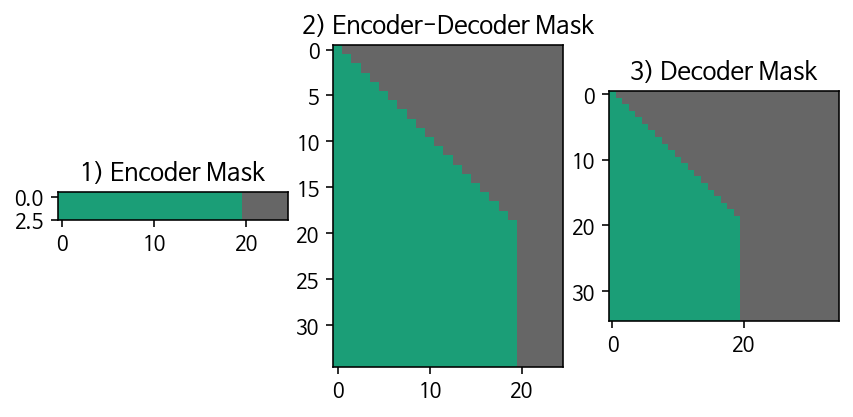

In [12]:
import matplotlib.pyplot as plt

batch, length = 16, 20
src_padding = 5
tgt_padding = 15

src_pad = tf.zeros(shape=(batch, src_padding))
tgt_pad = tf.zeros(shape=(batch, tgt_padding))

sample_data = tf.ones(shape=(batch, length))

sample_src = tf.concat([sample_data, src_pad], axis=-1)
sample_tgt = tf.concat([sample_data, tgt_pad], axis=-1)

enc_mask, dec_enc_mask, dec_mask = \
generate_masks(sample_src, sample_tgt)

fig = plt.figure(figsize=(7, 7))

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)

ax1.set_title('1) Encoder Mask')
ax2.set_title('2) Encoder-Decoder Mask')
ax3.set_title('3) Decoder Mask')

ax1.imshow(enc_mask[:3, 0, 0].numpy(), cmap='Dark2')
ax2.imshow(dec_enc_mask[0, 0].numpy(), cmap='Dark2')
ax3.imshow(dec_mask[0, 0].numpy(), cmap='Dark2')

plt.show()

첫 번째 마스크는 각 배치 별로 데이터의 꼬리 부분을 Masking 하는 형태임을 알 수 있습니다.

낯선 부분은 두 번째와 세 번째의 Decoder가 연관된 마스크인데... 이것이 바로 Causality Mask와 Padding Mask를 결합한 형태입니다.

자기 회귀적인 특성을 살리기 위해 Masked Multi-Head Attention에서 인과 관계 마스킹을 하는 것과 관련하여, 인과 관계를 가리는 것도 중요하지만 Decoder 역시 PAD 토큰은 피해 가야 하기 때문에 이런 형태의 마스크가 사용된다고 합니다.

이제 Tensorflow 상에서 잘 구동될 수 있도록 LearningRateSchedule 클래스를 상속받아 구현해봅시다.

여기서는 Learning Rate를 구현하고자 합니다.

In [13]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

print("완료🔥")

완료🔥


트랜스포머가 제안한 수식이 아니더라도 가변적인 Learning Rate를 사용하려면 위와 같이 구현을 하시면 됩니다.

Optimizer와 Scheduler를 연결하는 과정도 아주 간단하죠! Optimizer는 Adam을 사용하며, 세부 파라미터도 동일하게 맞춰줍니다.

# 💗 Project : 더 멋진 번역기 만들기 💗

## 0단계 - 환경 구성 및 데이터 준비

아래 링크에서 **korean-english-park.train.tar.gz** 를 사용할 예정입니다.

**링크 : https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1**

AIFFEL 클라우드 환경에서 작업이 진행되므로, 별도의 설치 없이 사전에 준비되어 있는 한국어-영어 데이터쌍을 사용합니다.

미리 준비되어 있는 데이터를 연결하기 위해, 아래와 같이 공유 디렉토리에 저장된 데이터를 가리키는 심볼릭 링크를 생성합니다.

심볼릭 링크를 연결한 결과는 아래와 같으며, 두 개의 파일이 들어 있네요!

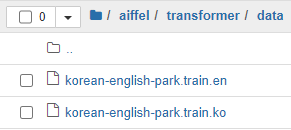

경로 설정에 관련하여 os를 import한 후, 아래와 같이 적용합니다.

In [14]:
import os

data_dir = os.getenv('HOME')+'/aiffel/transformer/data'
kor_path = data_dir + "/korean-english-park.train.ko"
eng_path = data_dir + "/korean-english-park.train.en"

## 1단계 - 데이터 정제 및 토큰화

파이썬 자료형에서 set는 중복을 허용하지 않습니다. 이를 활용해 **중복되는 데이터를 제거하고 남은 데이터를 cleaned_corpus에 저장합니다.**

이 때, 데이터의 병렬 쌍이 흐트러지지 않는 것이 중요합니다.

In [15]:
def clean_corpus(kor_path, eng_path):
    with open(kor_path, "r") as f: kor = f.read().splitlines()
    with open(eng_path, "r") as f: eng = f.read().splitlines()
    assert len(kor) == len(eng)
    
    cleaned_corpus = list(set(zip(kor, eng)))
    
    return cleaned_corpus
    
cleaned_corpus = clean_corpus(kor_path, eng_path)

정제된 corpus 데이터의 앞부분을 살펴봅시다.

In [16]:
print(cleaned_corpus[0:3])

[('의회가 위치한 컨벤션 센터는 이라크에서 경비가 가장 삼엄한 곳 중 하나이다.', 'The convention centre where parliament meets is one of the most heavily guarded buildings in the country.'), ('레알 마드리드 대변인은 “이번 기사에 대해 언급 할 수 없다”며 “의료진이 오는 6일 정기검진 결과를 제출할 때까지 팀 선수의 부상과 관련된 구체적인 상황을 밝힐 수 없다”고 덧붙였다.', "A club spokeswoman told Associated Press that she could not comment on the report, adding there would be no details regarding the injuries of any of the team's players until doctors submit their weekly update on Saturday."), ('- 네, 보이는군요.', '- Yeah, I can see them.')]


정제된 corpus 데이터의 개수는 몇 개일까요? 🙄🙄

In [17]:
print('정제된 corpus 데이터의 수는', len(cleaned_corpus), '개 입니다.')

정제된 corpus 데이터의 수는 78968 개 입니다.


한편, **노드에서 제시한 정제 함수의 조건**은 다음과 같이 정의되었습니다.

- 모든 입력은 소문자로 변환되어져야 합니다.
- 이 함수에서 살아남을 수 있는 문자는 알파벳, 문장부호, 한글 뿐입니다.
- 문장부호 양 사이드에는 공백이 추가되어져야 합니다.
- 문장 앞뒤로 불필요한 공백이 있다면 제거합니다.

위 조건을 만족시키는 정제 함수를 정의하기 위해 **정규 표현식**의 사용이 요구됩니다.

관련 모듈인 re를 import한 후 정제 함수를 정의해줍니다.

In [18]:
import re

def preprocess_sentence(sentence):
    # 모든 입력은 소문자로 변환
    sentence = sentence.lower()
    # 알파벳, 문장부호, 한글만 남기고 모두 제거
    sentence = re.sub(r"[^a-zA-Zㄱ-ㅎ가-힣ㅏ-ㅣ.,?!]+", " ", sentence)
    # 문장부호 양 사이드에 공백 추가
    sentence = re.sub(r"([,.?!])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence

한글 말뭉치 kor_corpus 와 영문 말뭉치 eng_corpus 를 각각 분리한 후, 정제합니다.

그 후 SentencePiece를 활용하여 토큰화를 진행합니다.

**https://github.com/google/sentencepiece**

링크된 사이트의 내용을 참고하여, 하기 조건을 만족시키는 **generate_tokenizer()** 함수를 정의내려 ko_tokenizer, en_tokenizer를 얻습니다.

추가적으로 **en_tokenizer에는 set_encode_extra_options("bos:eos") 함수를 실행**해, 타겟 입력이 문장의 시작 토큰과 끝 토큰을 포함할 수 있게 합니다.

- 단어 사전을 매개변수로 받아 원하는 크기의 사전을 정의할 수 있게 합니다. (기본: 20,000)
- 학습 후 저장된 model 파일을 SentencePieceProcessor() 클래스에 Load() 한 후 반환하도록 합니다.
- 특수 토큰의 인덱스를 제시된 조건에 따라 지정합니다. (**PAD : 0 / BOS : 1 / EOS : 2 / UNK : 3**)

In [19]:
import sentencepiece as spm

# Sentencepiece를 활용하여 학습한 tokenizer를 생성
def generate_tokenizer(corpus, vocab_size, lang="ko", pad_id=0, bos_id=1, eos_id=2, unk_id=3):
    # corpus를 받아 txt 파일로 저장
    temp_file = os.getenv('HOME') + f'/aiffel/aiffel_project_ksm/Going-Deeper/corpus_{lang}.txt'
    
    with open(temp_file, 'w') as f:
        for row in corpus:
            f.write(str(row) + '\n')
    
    # Sentencepiece
    spm.SentencePieceTrainer.Train(
        f'--input={temp_file} --pad_id={pad_id} --bos_id={bos_id} --eos_id={eos_id} \
        --unk_id={unk_id} --model_prefix=spm_{lang} --vocab_size={vocab_size}'
    )
    tokenizer = spm.SentencePieceProcessor()
    tokenizer.Load(f'spm_{lang}.model')

    return tokenizer

In [20]:
SRC_VOCAB_SIZE = TGT_VOCAB_SIZE = 20000

eng_corpus = []
kor_corpus = []

for pair in cleaned_corpus:
    k, e = pair[0], pair[1]

    kor_corpus.append(preprocess_sentence(k))
    eng_corpus.append(preprocess_sentence(e))

ko_tokenizer = generate_tokenizer(kor_corpus, SRC_VOCAB_SIZE, "ko")
en_tokenizer = generate_tokenizer(eng_corpus, TGT_VOCAB_SIZE, "en")
en_tokenizer.set_encode_extra_options("bos:eos")

True

In [21]:
cleaned_corpus[0]

('의회가 위치한 컨벤션 센터는 이라크에서 경비가 가장 삼엄한 곳 중 하나이다.',
 'The convention centre where parliament meets is one of the most heavily guarded buildings in the country.')

모든 데이터를 사용할 경우, 이후 진행되는 학습에서 상당히 오랜 시간을 소모하게 될 것입니다.

**토크나이저를 활용해 토큰의 길이가 50 이하인 데이터를 선별하여 src_corpus 와 tgt_corpus 를 각각 구축하고, 텐서 enc_train 과 dec_train 으로 변환하도록 합니다.**

In [22]:
from tqdm import tqdm_notebook # Process 과정을 보기 위해 tqdm_notebook이 사용됩니다.
import tqdm
import tensorflow as tf

src_corpus = []
tgt_corpus = []

assert len(kor_corpus) == len(eng_corpus)

# 토큰의 길이가 50 이하인 문장만 남깁니다.
for idx in tqdm_notebook(range(len(kor_corpus))):
    src = ko_tokenizer.EncodeAsIds(kor_corpus[idx])
    tgt = en_tokenizer.EncodeAsIds(eng_corpus[idx])
    
    if len(src) <= 50 and len(tgt) <= 50:
        src_corpus.append(src)
        tgt_corpus.append(tgt)
        
# 패딩처리를 완료하여 학습용 데이터를 완성합니다. 
enc_train = tf.keras.preprocessing.sequence.pad_sequences(src_corpus, padding='post')
dec_train = tf.keras.preprocessing.sequence.pad_sequences(tgt_corpus, padding='post')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


  0%|          | 0/78968 [00:00<?, ?it/s]

## 2단계 - 설계된 모델을 훈련시키기 위한 준비

본 프로젝트 시작 전에 미리 완성해 둔 Transformer 모델을 사용하므로, 설계 부분은 생략하고 훈련으로 넘어가겠습니다.

**이번 단계에서 주로 거치는 내용은 다음과 같습니다.**

- 꼭 2 Layer를 가지는 Transformer를 선언하도록 합니다. 단, 하이퍼파라미터는 자유롭게 조절할 수 있습니다.
- 논문에서 사용한 것과 동일한 Learning Rate Scheduler를 선언하고, 이를 포함하는 Adam Optimizer를 선언하도록 합니다. 이 때 Optimizer의 파라미터 역시 논문과 동일하게 설정합니다.
- Loss 함수를 정의하도록 합니다. Sequence-to-sequence 모델에서 사용했던 Loss와 유사하되, Masking되지 않은 입력의 개수로 Scaling하는 과정을 추가합니다. (트랜스포머가 모든 입력에 대한 Loss를 한 번에 구하기 때문입니다.)
- train_step 함수를 정의합니다. 입력 데이터에 알맞은 Mask를 생성하고, 이를 모델에 전달하여 연산에서 사용할 수 있게 합니다.

2 Layer Transformer 선언은 뒤에 가서 다루게 됩니다.

한편, 우리는 이전에 LearningRateScheduler 클래스를 선언했었죠? 다시 한 번 살펴봅시다.

In [23]:
class LearningRateScheduler(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(LearningRateScheduler, self).__init__()
        self.d_model = d_model
        self.warmup_steps = warmup_steps
    
    def __call__(self, step):
        arg1 = step ** -0.5
        arg2 = step * (self.warmup_steps ** -1.5)
        
        return (self.d_model ** -0.5) * tf.math.minimum(arg1, arg2)

learning_rate = LearningRateScheduler(512)
optimizer = tf.keras.optimizers.Adam(learning_rate,
                                     beta_1=0.9,
                                     beta_2=0.98, 
                                     epsilon=1e-9)

다음으로 Loss 함수를 정의합니다.

In [24]:
# Loss 함수 정의
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    # Masking 되지 않은 입력의 개수로 Scaling하는 과정
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)

train_step 함수도 정의합니다. 학습의 효율을 높이기 위해 **@tf.function()** 을 첨가해 주겠습니다.

In [25]:
@tf.function()
def train_step(src, tgt, model, optimizer):
    gold = tgt[:, 1:]
        
    enc_mask, dec_enc_mask, dec_mask = generate_masks(src, tgt)

    # 계산된 loss에 tf.GradientTape()를 적용해 학습을 진행합니다.
    with tf.GradientTape() as tape:
        predictions, enc_attns, dec_attns, dec_enc_attns = model(src, tgt, enc_mask, dec_enc_mask, dec_mask)
        loss = loss_function(gold, predictions[:, :-1])

    # 최종적으로 optimizer.apply_gradients()가 사용됩니다. 
    gradients = tape.gradient(loss, model.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    return loss, enc_attns, dec_attns, dec_enc_attns

## 3단계 - 설계된 모델 훈련시키기

본격적인 학습을 진행하기 위해, 노드에서 제시된 번역 생성 관련 소스를 사용하도록 하겠습니다.

In [26]:
# Attention 시각화 함수
def visualize_attention(src, tgt, enc_attns, dec_attns, dec_enc_attns):
    def draw(data, ax, x="auto", y="auto"):
        import seaborn
        seaborn.heatmap(data, 
                        square=True,
                        vmin=0.0, vmax=1.0, 
                        cbar=False, ax=ax,
                        xticklabels=x,
                        yticklabels=y)
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Encoder Layer", layer + 1)
        for h in range(4):
            draw(enc_attns[layer][0, h, :len(src), :len(src)], axs[h], src, src)
        plt.show()
        
    for layer in range(0, 2, 1):
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        print("Decoder Self Layer", layer+1)
        for h in range(4):
            draw(dec_attns[layer][0, h, :len(tgt), :len(tgt)], axs[h], tgt, tgt)
        plt.show()

        print("Decoder Src Layer", layer+1)
        fig, axs = plt.subplots(1, 4, figsize=(20, 10))
        for h in range(4):
            draw(dec_enc_attns[layer][0, h, :len(tgt), :len(src)], axs[h], src, tgt)
        plt.show()

In [27]:
# 번역 생성 함수
def evaluate(sentence, model, src_tokenizer, tgt_tokenizer):
    sentence = preprocess_sentence(sentence)
    pieces = src_tokenizer.encode_as_pieces(sentence)
    tokens = src_tokenizer.encode_as_ids(sentence)

    _input = tf.keras.preprocessing.sequence.pad_sequences([tokens], maxlen=enc_train.shape[-1], padding='post')
    
    print(len(_input))
    print(enc_train.shape[-1])

    ids = []
    output = tf.expand_dims([tgt_tokenizer.bos_id()], 0)
    for i in range(dec_train.shape[-1]):
        enc_padding_mask, combined_mask, dec_padding_mask = generate_masks(_input, output)
        
        # InvalidArgumentError: In[0] mismatch In[1] shape: 50 vs. 1: [1,8,1,50] [1,8,1,64] 0 0 [Op:BatchMatMulV2]
        predictions, enc_attns, dec_attns, dec_enc_attns = model(_input, output, enc_padding_mask, combined_mask, dec_padding_mask)
        
        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0, -1]).numpy().item()
        if tgt_tokenizer.eos_id() == predicted_id:
            result = tgt_tokenizer.decode_ids(ids)
            return pieces, result, enc_attns, dec_attns, dec_enc_attns

        ids.append(predicted_id)
        output = tf.concat([output, tf.expand_dims([predicted_id], 0)], axis=-1)
    result = tgt_tokenizer.decode_ids(ids)
    return pieces, result, enc_attns, dec_attns, dec_enc_attns

In [28]:
# 번역 생성 및 Attention 시각화 결합
def translate(sentence, model, src_tokenizer, tgt_tokenizer, plot_attention=False):
    pieces, result, enc_attns, dec_attns, dec_enc_attns = evaluate(sentence, model, src_tokenizer, tgt_tokenizer)
    
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    if plot_attention:
        visualize_attention(pieces, result.split(), enc_attns, dec_attns, dec_enc_attns)

이제.. 진짜 거의 다 왔습니다! 조금만 더 힘내요 😘😘

아까 2단계 절차 중에서 넘어갔던 부분인 2 Layer Transformer를 아래 코드로 선언할 수 있습니다! (하이퍼파라미터는 자유롭게 조정합니다!)

In [29]:
transformer = Transformer(
    n_layers=2,
    d_model=512,
    n_heads=8,
    d_ff = 2048,
    src_vocab_size=SRC_VOCAB_SIZE,
    tgt_vocab_size=TGT_VOCAB_SIZE,
    pos_len=200,
    dropout=0.2,
    shared=True
)

드디어 학습의 시간..입니다!! 모델이 좋은 번역 결과를 낼 수 있도록 기다리는 동안 기도합시다! 👰👰

In [30]:
print('당신의 tqdm 버전은', tqdm.__version__, '입니다.')

당신의 tqdm 버전은 4.56.0 입니다.


In [31]:
# 학습

## from tqdm import tqdm_notebook 
from tqdm.notebook import tqdm

BATCH_SIZE = 64
EPOCHS = 20

examples = [
            "습관처럼 조용히 눈을 감아.",
            "나에게 대답할 수 있을 것 같아,",
            "더이상 날 가두는 어둠에 눈 감지 않아.",
            "돌아오는 길을 알아."
]

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm_notebook(idx_list)

    for (batch, idx) in enumerate(t):
        batch_loss, enc_attns, dec_attns, dec_enc_attns = \
        train_step(enc_train[idx:idx+BATCH_SIZE],
                    dec_train[idx:idx+BATCH_SIZE],
                    transformer,
                    optimizer)

        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))

    for example in examples:
        translate(example, transformer, ko_tokenizer, en_tokenizer)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: they re , you re up .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: you re going to get to get .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: they were , they were about the same .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: they re , they re , and they re , he said .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: snow , snow s snow , snow , snow , snow , snow , snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i don t know how much , but i think about they would be , but it s not going to be , but it s not going to be  ⁇ 
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: the dow is a little bit like snow .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: he was , then , then , which was shot .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: they re looking for around .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i am , i can t think about what i can t get a lot of people , and i can t get a lot of people .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: the day , the bacteria is being held in the darkness of the year .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: the year old was returned to the return of the year .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: the quiet quiet quiet quietly .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i know what i will likely be right , and i know , if i can do .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: the longer , which has been around the globe .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: returning to the return of the road .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: the habit of her eyes and quiet .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: what you may have told me , i couldn t tell me , and i couldn t tell me , and i m just , and i m ding .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: the phoenix cuts in the wake of the long
1
50
Input: 돌아오는 길을 알아.
Predicted translation: returning to the area was .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: you can still live .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: what i m really good , you who respond to what s being responded to me , i ll respond to what i m telling me that i ll probably respond to me , i ll respond to what s .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: the long awaited in the darkness of rain .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: when i returned to the family .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: snow often s eyes .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer will respond to what i could be a new answer , you respond to me , what i could be responding to respond to respond to respond to the answer .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was caused by the darkness .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: when you return to the hospital .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: the teenage baby drops out of her eyes .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i ll answer somewhere from me , you ll be leaving me , you ll respond to you that .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was the biggest act of it .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: when i was d , then there was a long way to the family .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: snowy rarely silent .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i ll find a response to me , whatever you ll respond to me
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was taken into the military darkness .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i m just immediately , when they returned .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and you may like a snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer will i ask you that what s being d say .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was removed from the long running .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i would say when i was pretty good .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and closed .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i just ask me to answer , what i would like that i m sure that a new position , what i would like to do just that much good patient .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was taken near the lake began
1
50
Input: 돌아오는 길을 알아.
Predicted translation: after being paid a good oldhouse .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: you re still neighboring .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer my boats to help me , i ll be able to respond to what i ask me is that i could be , what i can you ll be .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was tested for ice
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i find the way a path .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and so as her eyes close .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to someone else  ⁇ 
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was likely getting a dark knight picked up what caused the dark knight picked up .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i justard music immediately , too .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and her eyes is a quiet , and you still snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to detain someone you ll believe that there is always to answer to everyone , you ll probably be sure that you would tell you what i would give you up to me to the many think suspicious province .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was taken to the rain forest forces .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i find the way immediately to tell me where the result was immediately , they know .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: often called snow , and sought for her snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i would tell you that what i m going to address the i m like that what i m like that i m sending them to me , what i can go to me over there .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it had been due to re pumping through the rain forest .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i return the way to new home .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: her play was snow particularly snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to me that i will always be able to answer , what i calls a new position , me capable of good soon .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it had been due to re pumping through the results .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i had i always had to say i was really good .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: snow , is hard to snow
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to me , you can ask that there , what i like i m like that , telling them what i likely will probably too , i would tell you what i m warning that i m warning .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it had been sealed off by the coast of california .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i return to the prime minister .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and hard consumer wears on her eyes .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to answer i d like that i can answer whatces an especially in many morning , me now , what i can do with i can .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was likely a matter of space act .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i was incredibly prime minister when they returned to a hospital .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: and hard is snow style .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to my friends immediately .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it was predicted for test fireville .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i return the way too soon .


  0%|          | 0/1064 [00:00<?, ?it/s]

1
50
Input: 습관처럼 조용히 눈을 감아.
Predicted translation: but , looks like her , and communications that s snow .
1
50
Input: 나에게 대답할 수 있을 것 같아,
Predicted translation: i answer to my friends over the morning .
1
50
Input: 더이상 날 가두는 어둠에 눈 감지 않아.
Predicted translation: it had lost theness of the water hazard in the area .
1
50
Input: 돌아오는 길을 알아.
Predicted translation: i was put out there .


## 학습 내용 평가

**약 2시간 30분 정도에 걸쳐 총 20번의 epoch을 수행하였으나, 결과는 만족스럽지 않았습니다.** 문제가 된 부분은 아래와 같습니다.

- 20번의 epoch이 진행될 동안, 다행스럽게도 학습을 거듭하면서 지속적으로 loss가 낮아지는 경향을 보였습니다.
- 대충 5번째 epoch까지 나온 문장들은 어떻게 보면 반복적이거나 혹은 그와 유사하게 나타난 문장들이 적어도 하나씩 존재하였습니다.
- 4개의 예문 중에서 마지막 문장을 예로 들어 설명하면, 분명 한국어 문장에 '나'라는 단어가 존재하지 않음에도 i나 you라는 주어로 쓰일 수 있는 단어가 대부분의 epoch에서 등장했습니다. 이것이 문장의 완성도를 위한 것이라면 굉장히 좋은 output이라고 볼 수 있을 듯 합니다.
- 하지만, 학습을 여러 번 한다고 해서 무조건적으로 만족할 만한 결과를 내놓지는 못하는 것을 확인할 수 있습니다. 돌아온다는 뜻을 가진 영어 단어인 return을 포함한 번역문이 나오지 않을까 했지만, 대표적으로 마지막 20번째 epoch에서는 그 단어를 찾을 수 없었습니다.
- 이러한 점을 들어, 구축된 Transformer 모델이 필자가 원했던 방향으로는 번역이 잘 되지는 않았던 것 같습니다.